#### Abstract
The data set refers to clients of a wholesale distributor. It includes the annual spending in monetary units (m.u.) on diverse product categories.
Our scope is to cluster clients and understand the main attributes of each group of customers, in order to use marketing to target them differently.

#### Load Libraries

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import mglearn

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

#### Import Dataset

In [4]:
data = pd.read_csv('Wholesale_customers_data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


Attribute Information:

1. FRESH: annual spending (m.u.) on fresh products (Continuous)
2. MILK: annual spending (m.u.) on milk products (Continuous)
3. GROCERY: annual spending (m.u.)on grocery products (Continuous)
4. FROZEN: annual spending (m.u.)on frozen products (Continuous)
5. DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6. DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous)
7. CHANNEL: customers Channel - Horeca (Hotel/Restaurant/Cafe) or Retail channel (Nominal)
8. REGION: customers Region Lisbon, Porto or Other (Nominal)

#### Summary Statistics

In [5]:
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


###### Analysis
From the description above, it is clear that, all columns apart from columns Channel and Region have a very low cardinality which can adversely affect ML algorithms, so they are exclude from the modelling phase.

In [6]:
# Check for null values
data.isnull().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [7]:
# Check the types of the data
data.dtypes

Channel             int64
Region              int64
Fresh               int64
Milk                int64
Grocery             int64
Frozen              int64
Detergents_Paper    int64
Delicassen          int64
dtype: object

In [8]:
# Check the shape of the dataframe
data.shape

(440, 8)

In [9]:
df = data.drop(['Channel','Region'], axis = 1)

#### Standardise our data
Lets start of with standardising our data since the scale of the features is different.

In [10]:
sc = StandardScaler()
sc_df = sc.fit_transform(df)

pd.DataFrame(sc_df, columns=df.columns).corr().style.background_gradient(cmap='YlGn')

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Fresh,1,0.10051,-0.0118539,0.345881,-0.101953,0.24469
Milk,0.10051,1,0.728335,0.123994,0.661816,0.406368
Grocery,-0.0118539,0.728335,1,-0.0401927,0.924641,0.205497
Frozen,0.345881,0.123994,-0.0401927,1,-0.131525,0.390947
Detergents_Paper,-0.101953,0.661816,0.924641,-0.131525,1,0.0692913
Delicassen,0.24469,0.406368,0.205497,0.390947,0.0692913,1


###### Analysis
We have high correlation among different features, for that reason we are going to perform dimentionality reduction using PCA

In [11]:
# Five principal components of the data
pca = PCA(n_components=5)

# Fit and transform onto the principal components
pca_train = pca.fit_transform(sc_df)

In [12]:
np.cumsum(pca.explained_variance_ratio_)

array([0.44082893, 0.72459292, 0.84793705, 0.94189209, 0.98950481])

We see that with 2 principal components we retain 72.4% of the variability. We will use only two since it is easier to plot. Ideally we should keep 4 components i.e. retain 94% of the variability

In [13]:
# two components of the data
pca = PCA(n_components=2)

# Fit and transform onto the first two principal components
pca_train = pca.fit_transform(sc_df)

In [14]:
pc = pd.DataFrame(pca_train, columns=['PC1','PC2'])
pc.head()

,PC1,PC2
0,0.193291,-0.305100
1,0.434420,-0.328413
2,0.811143,0.815096
3,-0.778648,0.652754
4,0.166287,1.271434


In [15]:
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
print('Explained variation overall: {}'.format(np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.44082893 0.283764  ]
Explained variation overall: 0.7245929240774496


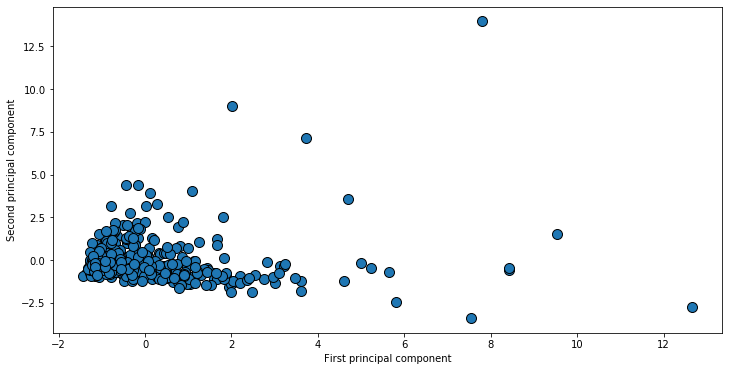

In [16]:
# plot first vs. second principal component
plt.figure(figsize = (12,6))
mglearn.discrete_scatter(pc.iloc[:, 0], pc.iloc[:, 1])

plt.xlabel("First principal component")
plt.ylabel("Second principal component")

plt.show()

#### Find optimum value of K

In [17]:
wscc = []
x = range(1,20)

for i in x:
    km = KMeans(n_clusters=i, init='k-means++')
    km.fit(pc)
    wscc.append(km.inertia_)

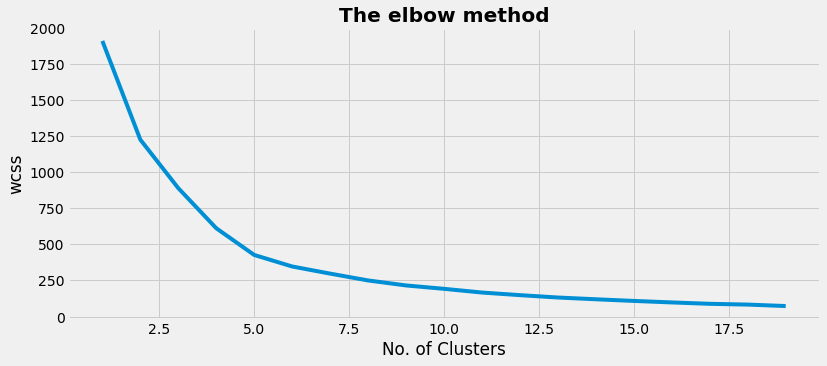

In [18]:
# Plotting
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))

plt.plot(x, wscc)

plt.title('The elbow method', fontdict={'fontweight': 'bold'})
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')

plt.show()

We notice that the Within-Cluster-Sum-of-Squares (WCSS) starts to flatten after 5 clusters, i.e. we do not reduce "significantly" within cluster variablilty so we will choose to assign our 440 customers to 5 clusters.

In [19]:
#K Means Clustering
kmean = KMeans(n_clusters=5, random_state=0).fit(pc)
y_kmeans = kmean.predict(pc)
lab = kmean.labels_

In [20]:
dataset = data.copy()
dataset['Cluster'] = y_kmeans
dataset.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669,9656,7561,214,2674,1338,2
1,2,3,7057,9810,9568,1762,3293,1776,0
2,2,3,6353,8808,7684,2405,3516,7844,3
3,1,3,13265,1196,4221,6404,507,1788,2
4,2,3,22615,5410,7198,3915,1777,5185,3


In [21]:
pc_conc = pd.concat([pc, dataset['Cluster']], axis = 1)
pc_conc.head()

,PC1,PC2,Cluster
0,0.193291,-0.305100,2
1,0.434420,-0.328413,0
2,0.811143,0.815096,3
3,-0.778648,0.652754,2
4,0.166287,1.271434,3


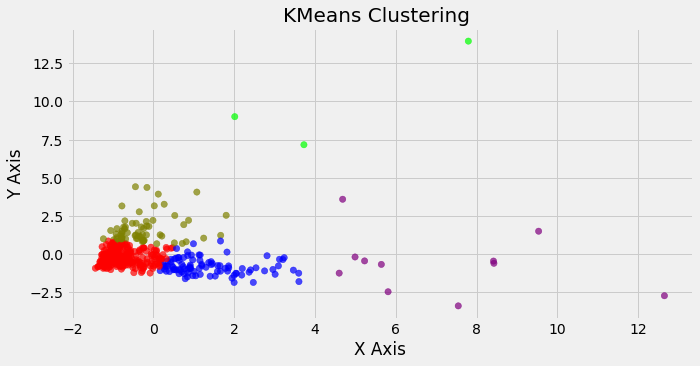

In [22]:
plt.figure(figsize=(10,5))
plt.title("KMeans Clustering ",fontsize=20)

plt.scatter(pc_conc['PC1'], pc_conc['PC2'],c = pc_conc['Cluster'], s=40, 
            cmap='brg',alpha=0.7,marker='o')
plt.xlabel("X Axis")
plt.ylabel("Y Axis")
plt.tight_layout
plt.show()

In [23]:
dataset.groupby('Cluster')[['Cluster']].count()

,Cluster
Cluster,
0,94
1,11
2,267
3,65
4,3


We notice that for two clusters we have very few customers. ideally we would like a uniform like distribution, but let's work with these.

In [24]:
dataset.groupby('Cluster').mean().style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,,,
0,1.92553,2.55319,5773.34,10348.5,16659.9,1268.8,7332.66,1517.81
1,2,2.54545,16911.1,34864.4,46126.2,3245.45,23008.1,4177.36
2,1.13483,2.51685,9630.56,2895.8,3867.94,2053.85,989.712,940.363
3,1.12308,2.63077,27666.8,5085.37,5237.92,8217.78,842.862,2602.14
4,1,2.66667,60571.7,30120.3,17314.7,38049.3,2153,20700.7


In [25]:
dataset.groupby('Cluster').mean().style.background_gradient(cmap='viridis')

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
Cluster,,,,,,,,
0,1.92553,2.55319,5773.34,10348.5,16659.9,1268.8,7332.66,1517.81
1,2,2.54545,16911.1,34864.4,46126.2,3245.45,23008.1,4177.36
2,1.13483,2.51685,9630.56,2895.8,3867.94,2053.85,989.712,940.363
3,1.12308,2.63077,27666.8,5085.37,5237.92,8217.78,842.862,2602.14
4,1,2.66667,60571.7,30120.3,17314.7,38049.3,2153,20700.7


- Cluster 0, is mostly from channel 2, they spend the least on Frozen, and very few on Delicassen and Fresh.
- Cluster 1, is only from channel 2, they have high spend in Milk, Grocery, Detergents_Paper.
- Cluster 2, very low in Detergents_Paper & Delicassen and they spend mostly for Fresh products.
- Cluster 3, is mostly from channel 1 and they spend very few for most of the products except for Fresh products.
- Cluste 4, is only from channel 1. They spend a lot for Fresh, Milk, Frozen and Delicassen, but very few for detergents_Paper

#### Convert the Region column to binary

In [32]:
df = dataset.join(pd.get_dummies(dataset.pop('Region')))

In [33]:
df.head()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster,1,2,3
0,2,12669,9656,7561,214,2674,1338,2,0,0,1
1,2,7057,9810,9568,1762,3293,1776,0,0,0,1
2,2,6353,8808,7684,2405,3516,7844,3,0,0,1
3,1,13265,1196,4221,6404,507,1788,2,0,0,1
4,2,22615,5410,7198,3915,1777,5185,3,0,0,1


In [34]:
df.rename(columns={1: 'Lisbon', 2: 'Porto', 3: 'Other Region'}, inplace = True)

In [35]:
df.head()

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster,Lisbon,Porto,Other Region
0,2,12669,9656,7561,214,2674,1338,2,0,0,1
1,2,7057,9810,9568,1762,3293,1776,0,0,0,1
2,2,6353,8808,7684,2405,3516,7844,3,0,0,1
3,1,13265,1196,4221,6404,507,1788,2,0,0,1
4,2,22615,5410,7198,3915,1777,5185,3,0,0,1


In [36]:
df.groupby('Cluster').mean().style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Lisbon,Porto,Other Region
Cluster,,,,,,,,,,
0,1.92553,5773.34,10348.5,16659.9,1268.8,7332.66,1517.81,0.159574,0.12766,0.712766
1,2,16911.1,34864.4,46126.2,3245.45,23008.1,4177.36,0.181818,0.0909091,0.727273
2,1.13483,9630.56,2895.8,3867.94,2053.85,989.712,940.363,0.187266,0.108614,0.70412
3,1.12308,27666.8,5085.37,5237.92,8217.78,842.862,2602.14,0.153846,0.0615385,0.784615
4,1,60571.7,30120.3,17314.7,38049.3,2153,20700.7,0,0.333333,0.666667


In [38]:
df.groupby('Cluster').mean().style.background_gradient(cmap='viridis')

,Channel,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Lisbon,Porto,Other Region
Cluster,,,,,,,,,,
0,1.92553,5773.34,10348.5,16659.9,1268.8,7332.66,1517.81,0.159574,0.12766,0.712766
1,2,16911.1,34864.4,46126.2,3245.45,23008.1,4177.36,0.181818,0.0909091,0.727273
2,1.13483,9630.56,2895.8,3867.94,2053.85,989.712,940.363,0.187266,0.108614,0.70412
3,1.12308,27666.8,5085.37,5237.92,8217.78,842.862,2602.14,0.153846,0.0615385,0.784615
4,1,60571.7,30120.3,17314.7,38049.3,2153,20700.7,0,0.333333,0.666667


For all clusters, the majority of clients are coming from Other Regions. For clusters 0 to 3, the number of clients from Lisbon is bigger than the number of clients from Porto. Except for cluster 4, in which there are not clients from Lisbon and the number of clients from Porto is exactly half of the clients from Other Region.